In [14]:
import numpy as np
import os
import random
import torch
import torch.nn as nn
from torchvision.transforms import transforms
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset
import math
import torch.nn.functional as F
import pandas as pd

def set_seed(seed=1):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(34)

In [36]:
df_train = pd.read_csv('../data/toydata/train_data.csv')
df_val = pd.read_csv('../data/toydata/val_data.csv')
df_test = pd.read_csv('../data/toydata/test_data.csv')

x_train, y_train = df_train['x'].values, df_train['y'].values
x_val, y_val = df_val['x'].values, df_val['y'].values
x_test, y_test, line = df_test['x'].values, df_test['y'].values, df_test['line'].values




In [37]:
class ToyDataset(Dataset):
    """Custom toy dataset"""

    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, idx):

        return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

def collate_fn(batch):

    x, y = zip(*batch)

    return torch.tensor(x)[:,None], torch.tensor(y)

In [38]:
# seed workers for reproducibility
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# g = torch.Generator()
# g.manual_seed(0)

traindata = ToyDataset(x_train, y_train)
trainloader = DataLoader(traindata, batch_size=500, shuffle=True, collate_fn=collate_fn, drop_last=True, pin_memory=True)

valdata = ToyDataset(x_val, y_val)
valloader = DataLoader(valdata, batch_size=500, shuffle=False, collate_fn=collate_fn, drop_last=True, pin_memory=True)

testdata = ToyDataset(x_test, y_test)
testloader = DataLoader(testdata, batch_size=len(y_test), shuffle=False, collate_fn=collate_fn, pin_memory=True)

NUM_BATCHES = len(trainloader)

In [39]:
class ScaleMixturePrior():
    def __init__(self, pi=0.5, sigma1=torch.exp(torch.tensor(0)), sigma2=torch.exp(torch.tensor(-6))):
        # self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.device = 'cpu'
        self.pi = pi
        self.mu = 0
        self.sigma1 = sigma1.to(self.device)
        self.sigma2 = sigma2.to(self.device)

    def prob(self, w, sigma):
        return (1 / (sigma * torch.sqrt(torch.tensor(2 * np.pi)))) * torch.exp(-0.5 * torch.pow((w - self.mu), 2) / torch.pow(sigma, 2))

    def log_prob(self, w):
        prob1 = self.prob(w, self.sigma1)
        prob2 = self.prob(w, self.sigma2)

        return torch.log(self.pi * prob1 + (1 - self.pi) * prob2).sum()

In [40]:
class Gaussian():
    def __init__(self, mu, rho):
        # self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.device = 'cpu'
        self.mu = mu.to(self.device)
        self.rho = rho.to(self.device)
        self.normal = torch.distributions.Normal(mu, self.sigma)
        
    @property
    def sigma(self):
        return torch.log1p(torch.exp(self.rho))

    def rsample(self):
        return self.normal.rsample().to(self.device)

    def log_prob(self, w):
        return self.normal.log_prob(w).sum()


In [41]:
class BayesianLinearLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        """
        """        
        self.input_dim = input_dim
        self.output_dim = output_dim

        # initialise mu and rho parameters so they get updated in backpropagation
        self.weight_mu = nn.Parameter(torch.Tensor(input_dim, output_dim).uniform_(-0.05, 0.05))
        self.weight_rho = nn.Parameter(torch.Tensor(input_dim, output_dim).uniform_(-2, -1)) 
        self.bias_mu = nn.Parameter(torch.Tensor(output_dim).uniform_(-0.05, 0.05))
        self.bias_rho = nn.Parameter(torch.Tensor(output_dim).uniform_(-2, -1))

        # initialise priors
        self.weight_prior = ScaleMixturePrior()
        self.bias_prior = ScaleMixturePrior()

        # initialise variational posteriors
        self.weight_posterior = Gaussian(self.weight_mu, self.weight_rho)
        self.bias_posterior = Gaussian(self.bias_mu, self.bias_rho)

        self.log_prior = 0.0
        self.log_variational_posterior = 0.0

    def forward(self, x, inference=False):

        if inference:
            w = self.weight_mu
            b = self.bias_mu

            self.log_prior = 0.0
            self.log_variational_posterior = 0.0

        else:
            w = self.weight_posterior.rsample()
            b = self.bias_posterior.rsample()

            self.log_prior = self.weight_prior.log_prob(w) + self.bias_prior.log_prob(b)
            self.log_variational_posterior = self.weight_posterior.log_prob(w) + self.bias_posterior.log_prob(b)

        output = torch.mm(x, w) + b

        # print("layer:", w.device, b.device, output.device, self.log_prior.device, self.log_variational_posterior.device)
        
        return output


In [42]:
class BayesianNeuralNetwork(nn.Module):
    def __init__(self, hidden_units1, hidden_units2, device="cpu"):
        super().__init__()
        """
        """
        self.layer1 = BayesianLinearLayer(1, hidden_units1)
        self.layer2 = BayesianLinearLayer(hidden_units1, hidden_units2)
        self.layer3 = BayesianLinearLayer(hidden_units2, 2)

        self.layers = [self.layer1, self.layer2, self.layer3]

        self.device = device

    def forward(self, x, inference=False):
        # print("x", x.device)
        x = F.relu(self.layer1(x.to(self.device), inference))
        x = F.relu(self.layer2(x.to(self.device), inference))
        x = self.layer3(x.to(self.device), inference)

        mu = x[:, 0]
        rho = x[:, 1]
        # print("mu", mu.device, "rho", rho.device, "x", x.device)
        return mu, rho

    def compute_log_prior(self):
        # model_log_prior = 0.0
        # for layer in self.layers:
        #     if isinstance(layer, BayesianLinearLayer):
        #         model_log_prior += layer.log_prior
        # print("model_log_prior", model_log_prior.device)
        # return model_log_prior
        return self.layer1.log_prior + self.layer2.log_prior + self.layer3.log_prior

    def compute_log_variational_posterior(self):
        model_log_variational_posterior = 0.0
        for layer in self.layers:
            if isinstance(layer, BayesianLinearLayer):
                model_log_variational_posterior += layer.log_variational_posterior
        # print("model_log_variational_posterior", model_log_variational_posterior.device)
        return model_log_variational_posterior
        # return self.layer1.log_variational_posterior + self.layer2.log_variational_posterior + self.layer3.log_variational_posterior
    
    def compute_NLL(self, mu, target, sigma):
        loss_fn = torch.nn.GaussianNLLLoss(reduction='sum', eps=1e-6)
        var = torch.pow(sigma, 2)
        NLL = loss_fn(mu, target, var)
        # print("NLL", NLL.device)
        return NLL
    
    def get_sigma(self, rho):
        # print("sigma", torch.log1p(torch.exp(rho)).device)
        return torch.log1p(torch.exp(rho))

    def compute_ELBO(self, input, target, n_samples=1):

        log_priors = torch.zeros(n_samples).to(self.device)
        log_variational_posteriors = torch.zeros(n_samples).to(self.device)
        NLLs = torch.zeros(n_samples).to(self.device)

        # for i in range(n_samples):
        #     mu, rho = self.forward(input, inference=False)
        #     sigma = self.get_sigma(rho)
        #     log_priors[i] = self.compute_log_prior()
        #     log_variational_posteriors[i] = self.compute_log_variational_posterior()
        #     NLLs[i] = self.compute_NLL(mu, target, sigma)

        mu, rho = self.forward(input, inference=True)
        sigma = self.get_sigma(rho)
        log_priors[0] = self.compute_log_prior()
        log_variational_posteriors[0] = self.compute_log_variational_posterior()
        NLLs[0] = self.compute_NLL(mu, target, sigma)

        log_prior = log_priors
        log_variational_posterior = log_variational_posteriors
        NLL = NLLs

        loss = ((log_variational_posterior - log_prior) / NUM_BATCHES) + NLL

        loss = loss.to(self.device)

        # print(loss, log_prior, log_variational_posterior, NLL)
 
        return loss, log_prior, log_variational_posterior, NLL



In [67]:
# useful functions 🤖

def train_BNN(model, optimizer, trainloader, valloader, epochs=500, model_name='BNN', val_every_n_epochs=10, device='cpu'):

    losses = []
    log_priors = []
    log_variational_posteriors = []
    NLLs = []

    val_losses = []
    val_log_priors = []
    val_log_variational_posteriors = []
    val_NLLs = []

    best_val_loss = np.inf

    for e in tqdm(range(epochs)):
        
        for x_, y_ in trainloader:

            model.train()

            x_, y_ = x_.float().to(device), y_.float().to(device)

            optimizer.zero_grad()

            loss, log_prior, log_posterior, log_NLL = model.compute_ELBO(x_, y_)
            # print(loss)

            # print(loss.device, log_prior.device, log_posterior.device, log_NLL.device)
            
            loss.backward()
            optimizer.step()

            losses.append(loss.item()) 
            log_priors.append(log_prior.item())
            log_variational_posteriors.append(log_posterior.item())
            NLLs.append(log_NLL.item()) 

        if (e+1) % val_every_n_epochs == 0:
            model.eval()

            val_loss_list = []
            with torch.no_grad():
                for val_x, val_y in valloader:
                    val_x, val_y = val_x.float().to(device), val_y.float().to(device)
                
                    val_loss, _ , _, _ = model.compute_ELBO(val_x, val_y)
                    val_loss_list.append(val_loss.item())

            val_losses.extend(val_loss_list)
            mean_val_loss = np.mean(val_loss_list)
            if mean_val_loss < best_val_loss:
                best_val_loss = mean_val_loss
                torch.save(model, f'{model_name}.pt')
            # print(f"Mean validation loss at epoch {e}: {mean_val_loss}")

    return losses, log_priors, log_variational_posteriors, NLLs, val_losses


def plot_loss(losses, val_losses):

    fig, ax = plt.subplots(1,2, figsize=(12,6))

    ax[0].plot(losses, label='Train loss')
    ax[0].set_title('Train loss')
    ax[0].set_xlabel('Iterations')
    ax[0].set_ylabel('Loss')

    ax[1].plot(val_losses, label='Validation loss', color='orange')
    ax[1].set_title('Validation loss')
    ax[1].set_xlabel('Iterations')
    ax[1].set_ylabel('Loss')

    plt.show()


def plot_log_probs(log_priors, log_variational_posteriors, NLLs):

    fig, ax = plt.subplots(1,3, figsize=(18,6))

    ax[0].plot(log_priors, label='Train log prior')
    ax[0].set_title('Train log prior')
    ax[0].set_xlabel('Iterations')
    ax[0].set_ylabel('Log prior')

    ax[1].plot(log_variational_posteriors, label='Train log variational posterior', color='orange')
    ax[1].set_title('Train log variational posterior')
    ax[1].set_xlabel('Iterations')
    ax[1].set_ylabel('Log variational posterior')

    ax[2].plot(NLLs, label='Train NLL', color='green')
    ax[2].set_title('Train NLL')
    ax[2].set_xlabel('Iterations')
    ax[2].set_ylabel('NLL')

    plt.show()

  0%|          | 0/5000 [00:00<?, ?it/s]

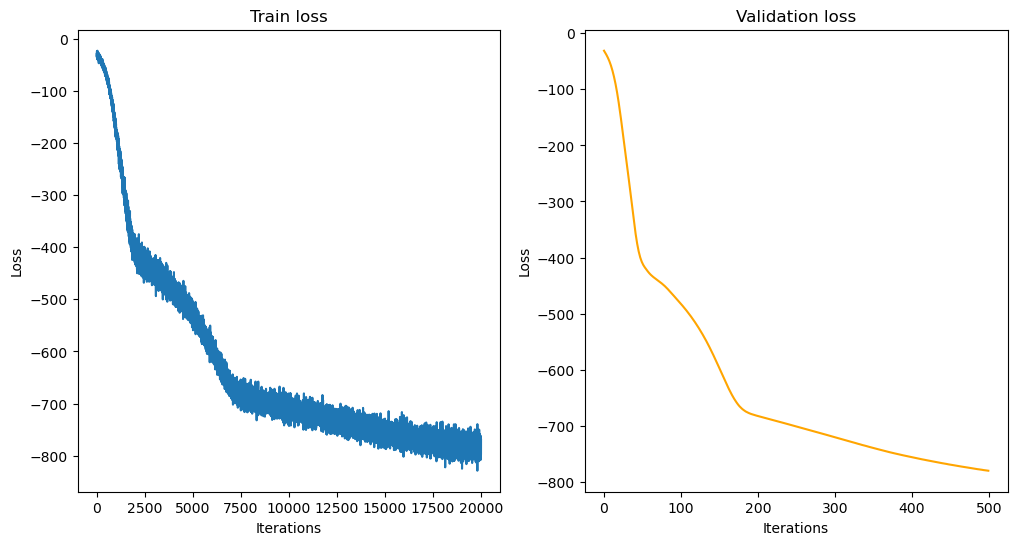

In [62]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'

# create model
BNN_model = BayesianNeuralNetwork(32, 128, device=device)
BNN_model = BNN_model.to(device)
optimizer = torch.optim.Adam(BNN_model.parameters(), lr=3e-5)

losses, log_priors, log_variational_posteriors, NLLs, val_losses = train_BNN(BNN_model, optimizer, trainloader, valloader, epochs=5000, model_name='BNN', val_every_n_epochs=10, device=device)

plot_loss(losses, val_losses)

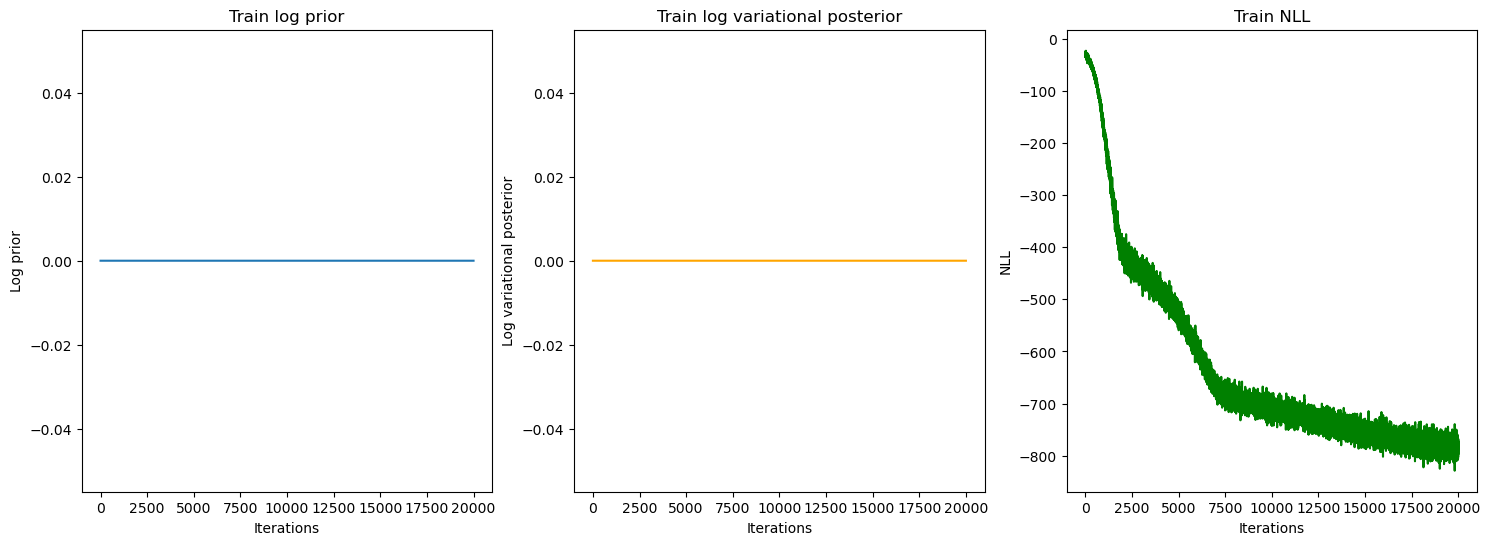

In [68]:
plot_log_probs(log_priors, log_variational_posteriors, NLLs)

In [69]:
model = torch.load("BNN.pt")

predictions = []
stds = []

for x_test, y_test in testloader:
    x_test, y_test = x_test.float(), y_test.float()
    with torch.no_grad():
        # output = model(x_test, inference=False)
        mu, rho = model(x_test, inference=True)
        # mu = output[:,0]
        # rho = output[:,1]
        sigma = model.get_sigma(rho)
        predictions.append(mu.cpu().detach().numpy())
        stds.append(sigma.cpu().detach().numpy())
        




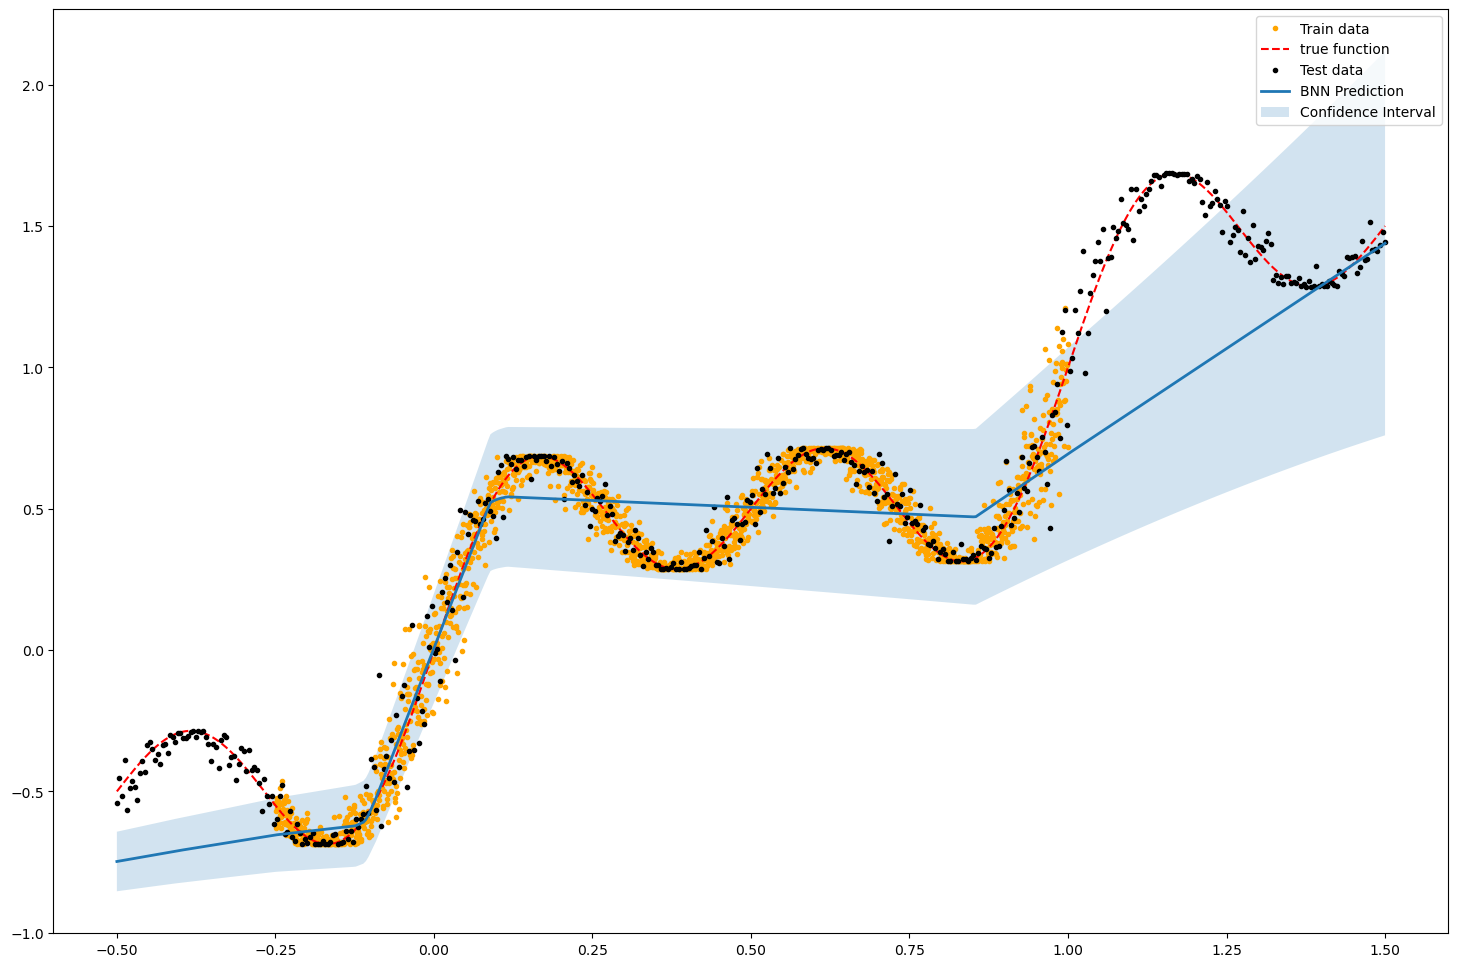

In [74]:
# plot data
fig, ax = plt.subplots(1,1, figsize=(18,12))

### plot mimo ###
plt.plot(x_train, y_train, '.', label='Train data', color='orange')
plt.plot(x_test[:,0], line, '--', label='true function', color='red')
# plot test data
plt.plot(x_test[:,0], y_test, '.', label='Test data', color='black')

# plot predicitons with confidence intervals
plt.plot(x_test[:,0], predictions[0], '-', label=f'BNN Prediction', linewidth=2)
plt.fill_between(x_test[:,0], predictions[0] - 1.96*stds[0], predictions[0] + 1.96*stds[0], alpha=0.2, label=f'Confidence Interval')

plt.legend()

plt.show()
